In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
from tqdm import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve, ShuffleSplit

# Setup

In [2]:
# Función óptima
def f(x):
    return np.exp(x)

In [3]:
# Tamaño de la muestra
N = 100

# Error irreducible
sigma_epsilon = 1

# Máximo de x
x_max = 2

# Punto para test
x_test = 1

# Vector de valores de x
x = x_max * (2 * np.random.rand(N) - 1)

# Ruido
epsilon = sigma_epsilon * np.random.randn(N)

# Función verdadera + ruido
y = f(x) + epsilon

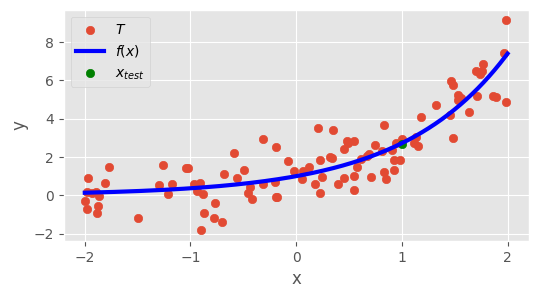

In [4]:
# Scatter plot
plt.figure(figsize=(6, 3))
x_range = np.linspace(-x_max, x_max, 1000)
plt.scatter(x, y, label=r'$T$')
plt.plot(x_range, f(x_range), 'b', linewidth=3.0, label=r'$f(x)$')
# Valor de la etiqueta en test
y_test = f(x_test) + sigma_epsilon * np.random.randn()
plt.scatter(x_test, y_test, c='g', label=r'$x_{test}$')
plt.xlabel('x', size=12)
plt.ylabel('y', size=12)
plt.xticks(np.arange(-x_max, x_max + 1))
plt.legend()
plt.show()

# Predicciones en un x fijo

In [5]:
# R datasets
R = 10000

# Punto para test
x_test = x_max * (2 * np.random.rand() - 1)

# max_depth de los árboles
depth_list = [1, None]

# Registramos las R predicciones en x_test
y_hat_test = np.zeros((len(depth_list), R))

# Iteramos en los R datasets
for r in tqdm(range(R)):
    # Tomamos una muestra de tamaño N
    x = x_max * (2 * np.random.rand(N) - 1) # Vector de valores de x
    epsilon = sigma_epsilon * np.random.randn(N) # Ruido
    y = f(x) + epsilon # Función verdadera + ruido

    # Calculamos la predicción para cada profundidad
    for k in range(len(depth_list)):
        # Construimos el árbol
        d = depth_list[k]
        tree = DecisionTreeRegressor(max_depth=d)

        # Entrenamos el árbol
        tree.fit(x.reshape(-1, 1), y)

        # Calculamos la predicción
        y_hat_test[k, r] = tree.predict(np.array([[x_test]])).item()

100%|██████████| 10000/10000 [00:04<00:00, 2112.40it/s]


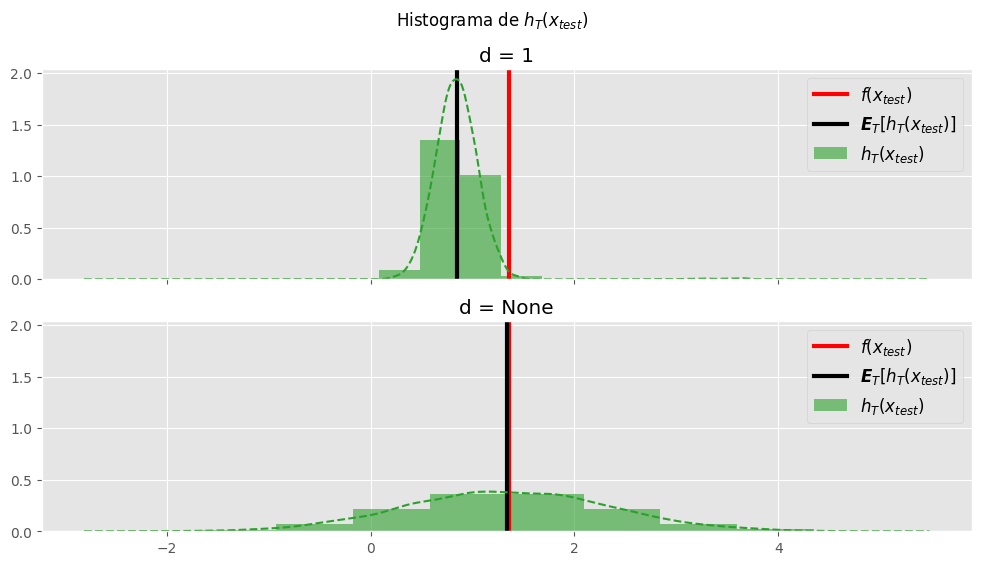

In [6]:
# Graficamos los resultados en un histograma

# Calculamos la predicción promedio y su desvío
y_hat_test_mean = np.mean(y_hat_test, 1)

fig, axs = plt.subplots(len(depth_list), 1, sharex=True, sharey=True, figsize=(12,6))

for k in range(len(depth_list)):
    axs[k].hist(y_hat_test[k], density=True, color='tab:green', alpha=0.6)
    xlim = axs[k].get_xlim()
    axs[k].axvline(x=f(x_test), color='r', linewidth=3.0)
    axs[k].axvline(x=y_hat_test_mean[k], color='k', linewidth=3.0)
    axs[k].title.set_text('d = {}'.format(depth_list[k]))
    axs[k].legend([r'$f(x_{test})$', r'$\boldsymbol{E}_T[h_T(x_{test})]$', r'$h_T(x_{test})$'], fontsize=12)

for k in range(len(depth_list)):
    x_range = np.linspace(xlim[0], xlim[1], 1000)
    kde = stats.gaussian_kde(y_hat_test[k])
    axs[k].plot(x_range, kde(x_range), color='tab:green', ls='--')

plt.suptitle(r'Histograma de $h_T(x_{test})$', size=12)
plt.show()

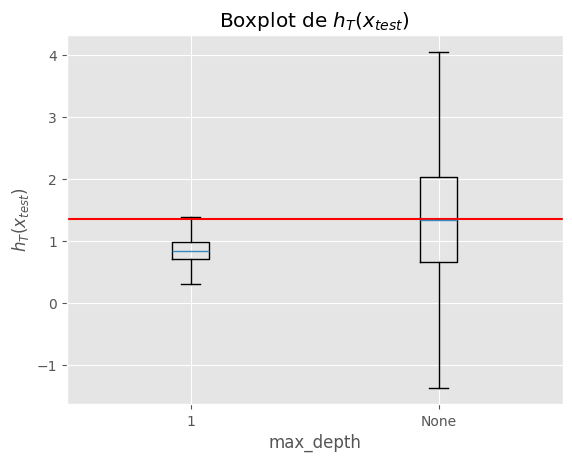

In [7]:
plt.boxplot(y_hat_test.T, showfliers=False)
plt.axhline(y=f(x_test), color='r')
plt.xlabel('max_depth', size=12)
plt.ylabel(r'$h_T(x_{test})$', size=12)
plt.xticks([1,2], [1, 'None'])
plt.title(r'Boxplot de $h_T(x_{test})$')
plt.show()

# Descomposición del error promediando en x

In [8]:
# R datasets
R = 10000

x_test = np.linspace(-x_max, x_max, 1000)

# max_depth de los árboles
depth_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None]

# Registramos las y en train
y_train = np.zeros((N, R))

# Registramos las y en test
y_test = np.zeros((len(x_test), R))

# Registramos las predicciones en train
y_hat_train = np.zeros((len(depth_list), N, R))

# Registramos las predicciones en test
y_hat_test = np.zeros((len(depth_list), len(x_test), R))

# Iteramos en los R datasets
for r in tqdm(range(R)):
    # Tomamos una muestra de tamaño N
    x = x_max * (2 * np.random.rand(N) - 1) # Vector de valores de x
    epsilon = sigma_epsilon * np.random.randn(N) # Ruido
    y = f(x) + epsilon # Función verdadera + ruido
    y_train[:,r] = y

    # Simulamos las etiquetas en x_test
    epsilon_test = sigma_epsilon * np.random.randn(len(x_test)) # Ruido
    y_test[:,r] = f(x_test) + epsilon_test # Función verdadera + ruido

    # Calculamos la predicción para cada profundidad
    for k in range(len(depth_list)):
        # Construimos el árbol
        d = depth_list[k]
        tree = DecisionTreeRegressor(max_depth=d)

        # Entrenamos el árbol
        tree.fit(x.reshape(-1, 1), y)

        # Predicción en train
        y_hat_train_k_r = tree.predict(x.reshape(-1,1))
        y_hat_train[k,:,r] = y_hat_train_k_r

        # Calculamos la predicción en test
        y_hat_test_k_r = tree.predict(x_test.reshape(-1,1))
        y_hat_test[k,:,r] = y_hat_test_k_r

100%|██████████| 10000/10000 [00:34<00:00, 290.42it/s]


In [9]:
# Calculamos error, sesgo y varianza
avg_train_squared_error = np.mean(np.square(y_hat_train-y_train),axis=(1,2))
avg_test_squared_error = np.mean(np.square(y_hat_test-y_test),axis=(1,2))
avg_bias_squared = np.mean(np.square(f(x_test)-np.mean(y_hat_test,axis=2)),axis=1)
avg_variance = np.mean(np.var(y_hat_test,axis=2),axis=1)

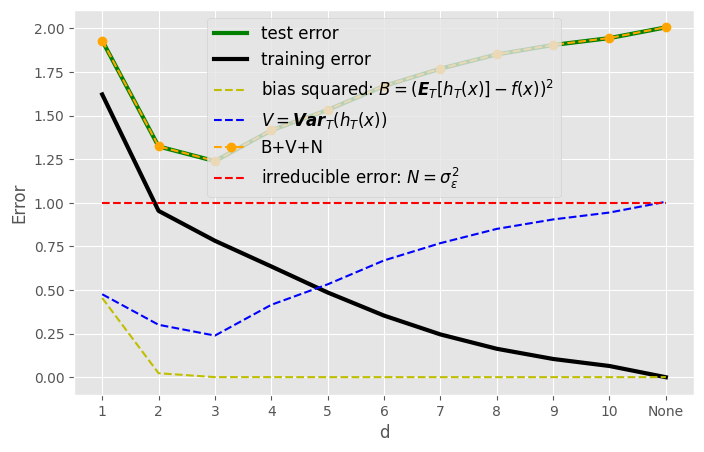

In [10]:
# Graficamos los resultados
d_arr = range(len(depth_list))
xticks_labels = [str(d) for d in depth_list]
plt.figure(figsize=(8, 5))
plt.plot(avg_test_squared_error, 'g', linewidth=3.0)
plt.plot(avg_train_squared_error, 'k', linewidth=3.0)
plt.plot(avg_bias_squared, 'y--')
plt.plot(avg_variance, 'b--')
plt.plot(avg_variance + avg_bias_squared + (sigma_epsilon ** 2) * np.ones_like(d_arr), 'o--', c='orange')
plt.plot((sigma_epsilon ** 2) * np.ones_like(d_arr), 'r--')
plt.xticks(d_arr, xticks_labels)
plt.ylabel('Error', size=12)
plt.xlabel('d', size=12)
plt.legend(['test error', 'training error', r'bias squared: $B=(\boldsymbol{E}_T[h_T(x)] - f(x))^2$',
            r'$V=\boldsymbol{Var}_T(h_T(x))$', 'B+V+N',r'irreducible error: $N=\sigma_\epsilon^2$'], loc='upper center', fontsize=12)
plt.show()

# Sesgo y Varianza: visualización para todo x en simultáneo

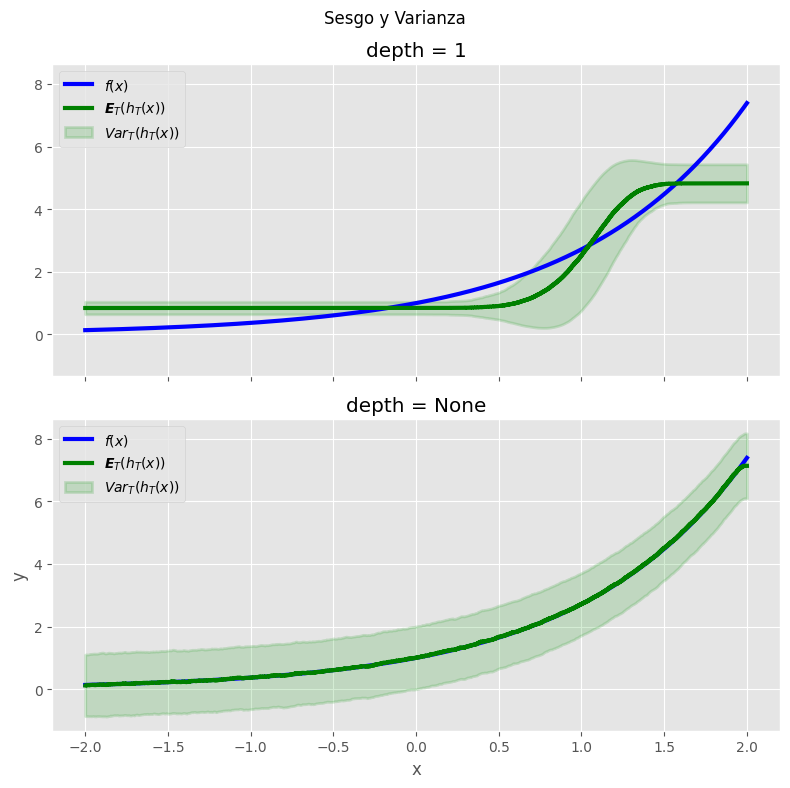

In [11]:
# R datasets
R = 10000

x_range = np.linspace(-x_max, x_max, 1000)

# max_depth de los árboles
depth_list = [1, None]

# Graficamos
fig, axs = plt.subplots(len(depth_list), 1, sharex=True, sharey=True, figsize=(8,8))

for k in range(len(depth_list)):
    # Iteramos en los R datasets
    y_hat_range = np.zeros((R,len(x_range)))
    for r in range(R):
        # Tomamos una muestra de tamaño N
        x = x_max * (2 * np.random.rand(N) - 1) # Vector de valores de x
        epsilon = sigma_epsilon * np.random.randn(N) # Ruido
        y = f(x) + epsilon # Función verdadera + ruido

        # Construimos el árbol
        d = depth_list[k]
        tree = DecisionTreeRegressor(max_depth=d)

        # Entrenamos el árbol
        tree.fit(x.reshape(-1, 1), y)

        # Predicción en train
        y_hat_range[r,:] = tree.predict(x_range.reshape(-1,1))

    # Graficamos la función verdadera
    y_hat_range_mean = np.mean(y_hat_range,axis=0)
    y_hat_range_std = np.std(y_hat_range,axis=0)
    axs[k].plot(x_range, f(x_range), 'b', linewidth=3.0)
    axs[k].step(x_range, y_hat_range_mean, 'g', linewidth=3.0)
    axs[k].fill_between(
        x_range,
        y_hat_range_mean - y_hat_range_std,
        y_hat_range_mean + y_hat_range_std,
        alpha=0.2,
        color="tab:green",
        lw=2,
    )
    axs[k].legend([r'$f(x)$',r'$\boldsymbol{E}_T(h_T(x))$',r'$Var_{T}(h_T(x))$'])

    axs[k].grid(True)
    axs[k].title.set_text('depth = {}'.format(depth_list[k]))

plt.xlabel('x')
plt.ylabel('y')
plt.suptitle(r'Sesgo y Varianza')
plt.tight_layout()
plt.show()

# Learning Curve

In [12]:
# Tomamos una muestra de tamaño N
N=1000
x = x_max * (2 * np.random.rand(N) - 1) # Vector de valores de x
epsilon = sigma_epsilon * np.random.randn(N) # Ruido
y = f(x) + epsilon # Función verdadera + ruido

In [13]:
# Instanciamos un árbol
depth = 1
tree = DecisionTreeRegressor(max_depth=depth)

In [14]:
# Definimos el splitter
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)

In [15]:
# learning curve
train_sizes, train_scores, test_scores = learning_curve(
    tree, x.reshape(-1,1), y, cv=cv, scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 100), n_jobs=-1, verbose=1, error_score='raise'
)

[learning_curve] Training set sizes: [ 80  87  94 101 109 116 123 130 138 145 152 160 167 174 181 189 196 203
 210 218 225 232 240 247 254 261 269 276 283 290 298 305 312 320 327 334
 341 349 356 363 370 378 385 392 400 407 414 421 429 436 443 450 458 465
 472 480 487 494 501 509 516 523 530 538 545 552 560 567 574 581 589 596
 603 610 618 625 632 640 647 654 661 669 676 683 690 698 705 712 719 727
 734 741 749 756 763 770 778 785 792 800]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:    5.8s finished


In [16]:
# Calculamos los errores medios y sus desvíos
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std  = np.std(train_scores, axis=1)
test_scores_mean  = -np.mean(test_scores, axis=1)
test_scores_std   = np.std(test_scores, axis=1)

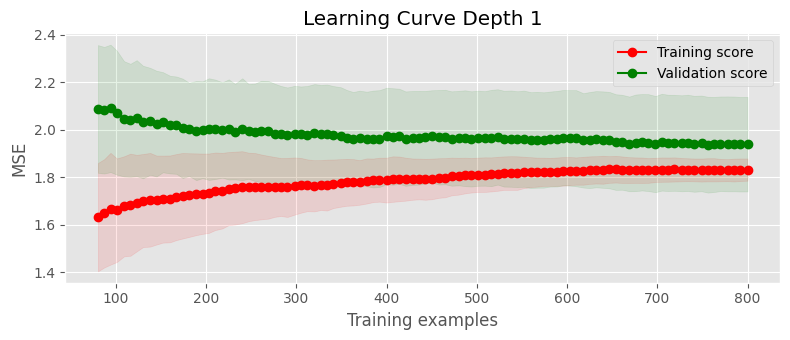

In [17]:
# Graficamos
plt.figure(figsize=(8, 3.5))
plt.title(f'Learning Curve Depth {depth}')
plt.xlabel("Training examples")
plt.ylabel("MSE")

plt.fill_between(train_sizes,
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std,
                 alpha=0.1, color="r")
plt.fill_between(train_sizes,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation score")

plt.legend(loc="best")
plt.tight_layout()
plt.show()